# DATA-641 News Summarization Project
#### Max Calzada, Josiah Gottfried
2023 May 10

In [ ]:
import numpy as np
import pandas as pd
import re
from re import search
import string
import random
import matplotlib.pyplot as plt
from joblib import dump, load

In [ ]:
# check device name
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

GPU device not found


# Step 1: [Webscraping](https://realpython.com/python-web-scraping-practical-introduction/)
(Max & Josiah)

In [ ]:
# web-scraping
import requests
from bs4 import BeautifulSoup

## BBC News

### Current

In [ ]:
url = 'https://www.bbc.com/news'
response = requests.get(url)

# find all headlines
soup = BeautifulSoup(response.text, 'html.parser')
headlines = soup.find('body').find('div', id = 'latest-stories-tab-container').find_all('a', class_ = 'gs-c-promo-heading')

# data frame with headlines and links
headlinesDF_bbc = pd.DataFrame({"headline": [x.find(class_ = 'gs-c-promo-heading__title').text.strip() for x in headlines],
                            "link": [x['href'] for x in headlines]})

# drop duplicates
headlinesDF_bbc = headlinesDF_bbc.drop_duplicates(ignore_index = True)
headlinesDF_bbc

,headline,link
0,Wagner boss says he will pull troops out of Ba...,/news/world-europe-65493008
1,What it's like inside Russia 14 months after i...,/news/world-europe-65454203
2,Vow to disarm Serbia after mass shootings,/news/world-europe-65500203
3,"Covid global health emergency is over, WHO says",/news/health-65499929
4,Nasa animation puts black holes in perspective,/news/world-us-canada-65501275
5,Idea of paying homage abhorrent to King - Dimb...,/news/uk-65493188
6,China hits out at Canada over claim it targete...,/news/world-us-canada-65487195
7,Man arrested for opening hard drugs store in C...,/news/world-us-canada-65487199
8,Drought prompts French ban on garden swimming ...,/news/world-europe-65494306
9,Trainer suspended after horses die at Kentucky...,/sport/horse-racing/65492312


In [ ]:
def get_bbc_article(url, ShowErrorUrls = False):
    """
    This function gets the article text and LEAD-3 from a given link to a BBC News or Sport article.
    """
    
    try:
        
        response = requests.get(url)
        soup = BeautifulSoup(response.text, "html.parser")
        
        if "live" in url: # live articles have an irregular format
            return "", ""
        
        # BBC News article
        if "news" in url:
            
            if "world_radio_and_tv" in url: # news/world_radio_and_news is not an article
                return "", ""
            else:
                # make a list of all text blocks in the article (these contain the article text)
                article = soup.find("body").find("main", id = "main-content").find_all("div", attrs = {"data-component": "text-block"})
        
        # BBC Sport article (sport articles have a different from news articles)
        elif "sport" in url:
            # make a list of all <p>, which contain the article text
            article = soup.find("body").find("div", class_ = "qa-story-body").find_all("p")
        
        # any headlines from BBC Reel, Worklife, Travel, Future, Culture, TV, Weather, and Sounds will be ommitted
        else:
            return "", ""

        # join sentences into article and LEAD-3
        article_text = " ".join([x.text.strip() for x in article])
        lead3 = " ".join([x.text.strip() for x in article][:3])
    
    # return blank if there is an error
    except:
        
        # print problematic url if requested
        if ShowErrorUrls:
            print(url)
            
        return "", ""
    
    return article_text, lead3   

In [ ]:
# prepend https://www.bbc.com to any URLs that do not include this
headlinesDF_bbc["link"] = [url if "https" in url else ("https://www.bbc.com" + url) for url in headlinesDF_bbc["link"]]

<ipython-input-6-1e0c996730d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  headlinesDF_bbc["link"] = [url if "https" in url else ("https://www.bbc.com" + url) for url in headlinesDF_bbc["link"]] # results in a list of tuples; each tuple has the form (article, lead3)


In [ ]:
# get article text and LEAD-3 for each link
articles_list = [get_bbc_article(url) for url in headlinesDF_bbc["link"]] # list of tuples in the format (article full text, LEAD-3)
headlinesDF_bbc["article"] = [article[0] for article in articles_list] # get article full text
headlinesDF_bbc["lead3"] = [article[1] for article in articles_list] # get LEAD-3
headlinesDF_bbc = headlinesDF_bbc[headlinesDF_bbc['lead3'].astype(bool)].reset_index(drop = True) # drop blanks
headlinesDF_bbc

<ipython-input-7-3b0c51a480a6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  headlinesDF_bbc["article"] = [article[0] for article in articles_list]
<ipython-input-7-3b0c51a480a6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  headlinesDF_bbc["lead3"] = [article[1] for article in articles_list]


,headline,link,article,lead3
0,Wagner boss says he will pull troops out of Ba...,https://www.bbc.com/news/world-europe-65493008,The leader of Russia's Wagner mercenary group ...,The leader of Russia's Wagner mercenary group ...
1,Vow to disarm Serbia after mass shootings,https://www.bbc.com/news/world-europe-65500203,"Serbia's president has pledged ""an almost comp...","Serbia's president has pledged ""an almost comp..."
2,"Covid global health emergency is over, WHO says",https://www.bbc.com/news/health-65499929,The World Health Organization (WHO) has declar...,The World Health Organization (WHO) has declar...
3,Idea of paying homage abhorrent to King - Dimb...,https://www.bbc.com/news/uk-65493188,The King would find the idea of people paying ...,The King would find the idea of people paying ...
4,China hits out at Canada over claim it targete...,https://www.bbc.com/news/world-us-canada-65487195,"China has accused Canada of ""slander and defam...","China has accused Canada of ""slander and defam..."
5,Man arrested for opening hard drugs store in C...,https://www.bbc.com/news/world-us-canada-65487199,A Canadian man has been arrested in British Co...,A Canadian man has been arrested in British Co...
6,Drought prompts French ban on garden swimming ...,https://www.bbc.com/news/world-europe-65494306,Garden swimming pools are to be banned from sa...,Garden swimming pools are to be banned from sa...
7,Trainer suspended after horses die at Kentucky...,https://www.bbc.com/sport/horse-racing/65492312,Trainer Saffie Joseph Jr has been suspended af...,Trainer Saffie Joseph Jr has been suspended af...
8,Prosecutors investigate Mar-a-Lago security fo...,https://www.bbc.com/news/world-us-canada-65499141,Prosecutors investigating Donald Trump's handl...,Prosecutors investigating Donald Trump's handl...
9,Ex-Uber security chief sentenced for hack cove...,https://www.bbc.com/news/technology-65497186,Uber's former chief security officer has avoid...,Uber's former chief security officer has avoid...


### Archives

In [ ]:
# list of dates for each day in 2022
year = [d.strftime('%Y%m%d') for d in pd.date_range('20220101','20221231')] # https://stackoverflow.com/questions/18684076/how-to-create-a-list-of-date-string-in-yyyymmdd-format-with-python-pandas

In [ ]:
def get_bbc_articles_for(date):
    
    # get url for date
    url = "http://web.archive.org/web/{}/https://www.bbc.com/news".format(date)
    response = requests.get(url)
    
    # find all headlines
    soup = BeautifulSoup(response.text, "html.parser")
    headings_html = soup.find("body").find("div", id = "latest-stories-tab-container").find_all("a", class_ = "gs-c-promo-heading")
    
    # lists of headlines and links
    headlines = []
    links = []
    for x in headings_html:
        headline = x.find(class_ = "gs-c-promo-heading__title").text.strip()
        link = x["href"]
        if headline not in headlines: # don't include duplicate headlines
            headlines.append(headline)
            links.append(link)
    
    # prepend http://web.archive.org to any URLs that do not include this
    links = [url if "http:" in url else ("http://web.archive.org" + url) for url in links]
    
    # get article text and LEAD-3 for each link
    article_tuples = [get_bbc_article(url) for url in links] # list of tuples in the format (article full text, LEAD-3)
    articles = [article[0] for article in article_tuples] # get article full text
    lead3s = [article[1] for article in article_tuples] # get LEAD-3
    
    # add dates and sources
    dates = [date for _ in range(len(headlines))]
    
    # check length of lists    
    if not (len(headlines) == len(links) == len(articles) == len(lead3s) == len(dates)):
        raise Exception("Something went wrong. List lengths are unequal.")
        print(len(headlines), len(links), len(articles), len(lead3s), len(dates))
    
    # return dataframe
    return headlines, links, articles, lead3s, dates

In [ ]:
headlines = []
links = []
articles = []
lead3s = []
dates = []
for day in year[:10]:
    print(day)
    new_headlines, new_links, new_articles, new_lead3s, new_dates = get_bbc_articles_for(day)
    headlines.extend(new_headlines)
    links.extend(new_links)
    articles.extend(new_articles)
    lead3s.extend(new_lead3s)
    dates.extend(new_dates)

In [ ]:
headlinesDF_bbc = pd.DataFrame({"headline": headlines, "link": links, "article": articles, "lead3": lead3s, "date": dates})
headlinesDF_bbc.shape

In [ ]:
headlinesDF_bbc = headlinesDF_bbc[headlinesDF_bbc['lead3'].astype(bool)].reset_index(drop = True) # drop blanks
headlinesDF_bbc.shape

In [ ]:
headlinesDF_bbc["source"] = "BBC"

## CBS News

### Current

In [ ]:
url = 'https://www.cbsnews.com/us/'
response = requests.get(url)

# find all headlines
soup = BeautifulSoup(response.text, 'html.parser')
headlines = soup.find('body').find('div', class_ = 'component__item-wrapper').find_all('article', class_ = 'item')

# data frame with headlines and links
headlinesDF_cbs = pd.DataFrame({"headline": [x.find('h4', class_ = 'item__hed').text.strip() for x in headlines ],
                            "link": [x.find('a')['href']for x in headlines]})

# drop duplicates
headlinesDF_cbs = headlinesDF_cbs.drop_duplicates(ignore_index = True)

In [ ]:
headlinesDF_cbs

,headline,link
0,Will Social Security run out — and what happen...,https://www.cbsnews.com/news/will-social-secur...
1,MLB player changes uniform number to mark the ...,https://www.cbsnews.com/news/sandy-leon-mlb-un...
2,Is your money safe in the bank right now?,https://www.cbsnews.com/news/is-my-money-safe-...
3,Alabama inmate pleads guilty to escape; felony...,https://www.cbsnews.com/news/casey-white-vicky...
4,Trump's E. Jean Carroll deposition video released,https://www.cbsnews.com/news/trump-trial-e-jea...
5,Feds probe incident where woman died in flamin...,https://www.cbsnews.com/news/dodge-journey-nht...
6,CDC director Rochelle Walensky leaving the agency,https://www.cbsnews.com/news/rochelle-walensky...
7,State prosecutors investigate workplace violat...,https://www.cbsnews.com/news/nfl-workplace-inv...
8,Pete Davidson mourns death of his 2-year-old dog,https://www.cbsnews.com/news/pete-davidson-dog...
9,Arrest made in connection to Lauren Heike's death,https://www.cbsnews.com/news/lauren-heike-deat...


In [ ]:
def get_cbs_article(url, ShowErrorUrls = False):
    
    try:
        
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')

        article = soup.find('body').find('section', class_ = 'content__body').find_all('p')

        # join sentences into article and LEAD-3
        article_text = ' '.join([x.text.strip() for x in article])
        lead3 = ' '.join([x.text.strip() for x in article][:3])
    
    except:
        
        # print problematic url if requested
        if ShowErrorUrls:
            print(url)
            
        return "", ""
    
    return article_text, lead3

In [ ]:
# get article text and LEAD-3 for each link
articles_list = [get_cbs_article(url) for url in headlinesDF_cbs["link"]] # list of tuples in the format (article full text, LEAD-3)
headlinesDF_cbs["article"] = [article[0] for article in articles_list] # get article full text
headlinesDF_cbs["lead3"] = [article[1] for article in articles_list] # get LEAD-3
headlinesDF_cbs = headlinesDF_cbs[headlinesDF_cbs['lead3'].astype(bool)].reset_index(drop = True) # drop blanks

[<p>It's no wonder the majority of millennials say they <span class="link"><a data-invalid-url-rewritten-http="" href="https://www.cbsnews.com/news/retirement-social-security-millennials-plan-on-help-from-kids/" target="_blank">aren't factoring</a></span> Social Security benefits into their retirement planning, for years they've been hearing that the retirement and disability program is going bust. </p>, <p>Their belief is based on projections such as from the most recent <a href="https://blog.ssa.gov/social-security-2023-trustees-report/" rel="nofollow noopener" target="_blank">Social Security Trustees Report</a> showing that Social Security's trust fund reserves will be depleted in 2033. That's one year sooner than the program's trustees had projected last year, and is partly due to shifts such as slowing economic growth.</p>, <p>Yet experts say that some Americans, especially younger workers, have misunderstandings about the impact if the trust fund indeed goes bust — a prediction, 

In [ ]:
headlinesDF_cbs

,headline,link,article,lead3
0,Will Social Security run out — and what happen...,https://www.cbsnews.com/news/will-social-secur...,It's no wonder the majority of millennials say...,It's no wonder the majority of millennials say...
1,MLB player changes uniform number to mark the ...,https://www.cbsnews.com/news/sandy-leon-mlb-un...,Sandy León has worn many jersey numbers during...,Sandy León has worn many jersey numbers during...
2,Is your money safe in the bank right now?,https://www.cbsnews.com/news/is-my-money-safe-...,Recent turmoil in the banking industry may hav...,Recent turmoil in the banking industry may hav...
3,Alabama inmate pleads guilty to escape; felony...,https://www.cbsnews.com/news/casey-white-vicky...,An Alabama inmate charged in the death of a ja...,An Alabama inmate charged in the death of a ja...
4,Trump's E. Jean Carroll deposition video released,https://www.cbsnews.com/news/trump-trial-e-jea...,Attorneys for the writer E. Jean Carroll relea...,Attorneys for the writer E. Jean Carroll relea...
5,Feds probe incident where woman died in flamin...,https://www.cbsnews.com/news/dodge-journey-nht...,U.S. safety regulators are investigating possi...,U.S. safety regulators are investigating possi...
6,CDC director Rochelle Walensky leaving the agency,https://www.cbsnews.com/news/rochelle-walensky...,Washington — Dr. Rochelle Walensky is stepping...,Washington — Dr. Rochelle Walensky is stepping...
7,State prosecutors investigate workplace violat...,https://www.cbsnews.com/news/nfl-workplace-inv...,Attorneys general in California and New York s...,Attorneys general in California and New York s...
8,Pete Davidson mourns death of his 2-year-old dog,https://www.cbsnews.com/news/pete-davidson-dog...,Pete Davidson is mourning the loss of his 2-ye...,Pete Davidson is mourning the loss of his 2-ye...
9,Arrest made in connection to Lauren Heike's death,https://www.cbsnews.com/news/lauren-heike-deat...,Police in Phoenix have arrested a man in conne...,Police in Phoenix have arrested a man in conne...


### Archives

In [ ]:
# list of dates for each day in 2022
year = [d.strftime('%Y%m%d') for d in pd.date_range('20220201','20220331')] # https://stackoverflow.com/questions/18684076/how-to-create-a-list-of-date-string-in-yyyymmdd-format-with-python-pandas

In [ ]:
def get_cbs_articles_for(date):
    
    # get url for date
    url = "http://web.archive.org/web/{}/https://www.cbsnews.com/us".format(date)
    response = requests.get(url)
    
    # find all headlines
    soup = BeautifulSoup(response.text, 'html.parser')
    headings_html = soup.find('body').find('div', class_ = 'component__item-wrapper').find_all('article', class_ = 'item')
    
    # lists of headlines and links
    headlines = []
    links = []
    for x in headings_html:
        headline = x.find('h4', class_ = 'item__hed').text.strip()
        link = x.find('a')['href']
        if headline not in headlines: # don't include duplicate headlines
            headlines.append(headline)
            links.append(link)
    
    # get article text and LEAD-3 for each link
    article_tuples = [get_cbs_article(url) for url in links] # list of tuples in the format (article full text, LEAD-3)
    articles = [article[0] for article in article_tuples] # get article full text
    lead3s = [article[1] for article in article_tuples] # get LEAD-3
    
    # add dates and sources
    dates = [date for _ in range(len(headlines))]
    
    # check length of lists    
    if not (len(headlines) == len(links) == len(articles) == len(lead3s) == len(dates)):
        raise Exception("Something went wrong. List lengths are unequal.")
        print(len(headlines), len(links), len(articles), len(lead3s), len(dates))
    
    # return dataframe
    return headlines, links, articles, lead3s, dates

In [ ]:
headlines = []
links = []
articles = []
lead3s = []
dates = []
for day in year[:10]:
    print(day)
    new_headlines, new_links, new_articles, new_lead3s, new_dates = get_cbs_articles_for(day)
    headlines.extend(new_headlines)
    links.extend(new_links)
    articles.extend(new_articles)
    lead3s.extend(new_lead3s)
    dates.extend(new_dates)

In [ ]:
headlinesDF_cbs = pd.DataFrame({"headline": headlines, "link": links, "article": articles, "lead3": lead3s, "date": dates})
headlinesDF_cbs.shape

In [ ]:
headlinesDF_cbs = headlinesDF_cbs[headlinesDF_cbs['lead3'].astype(bool)].reset_index(drop = True) # drop blanks
headlinesDF_cbs.shape

In [ ]:
headlinesDF_cbs["source"] = "CBS"

## NBC News

### Current

In [ ]:
url = 'https://www.nbcnews.com'
response = requests.get(url)

# find all headlines
soup = BeautifulSoup(response.text, 'html.parser')
headlines = soup.find('body').find('div', class_ = 'layout-container').find_all(['h2', 'h3'], class_ = re.compile('headline'))

# data frame with headlines and links
headlinesDF_nbc = pd.DataFrame({"headline": [x.text.strip() if x.a is None else x.a.text.strip() for x in headlines],
                                "link": [x.parent["href"] if x.a is None else x.a["href"] for x in headlines]})

# drop duplicates
headlinesDF_nbc = headlinesDF_nbc.drop_duplicates(ignore_index = True)
headlinesDF_nbc

NameError: ignored

In [ ]:
def get_nbc_article(url, ShowErrorUrls = False):
    """
    This function gets the article text and LEAD-3 from a given link to a nbc article.
    """
    
    try:
        
        response = requests.get(url)
        soup = BeautifulSoup(response.text, "html.parser")
        
        article = soup.body.find("div", class_ = "article-body__content").find_all("p")

        # join sentences into article and LEAD-3
        article_text = " ".join([x.text.strip() for x in article])
        lead3 = " ".join([x.text.strip() for x in article][:3])
    
    # return blank if there is an error
    except:
        
        # print problematic url if requested
        if ShowErrorUrls:
            print(url)
            
        return "", ""
    
    return article_text, lead3 

In [ ]:
# get article text and LEAD-3 for each link
articles_list = [get_nbc_article(url) for url in headlinesDF_nbc["link"]] # list of tuples in the format (article full text, LEAD-3)
headlinesDF_nbc["article"] = [article[0] for article in articles_list] # get article full text
headlinesDF_nbc["lead3"] = [article[1] for article in articles_list] # get LEAD-3
headlinesDF_nbc = headlinesDF_nbc[headlinesDF_nbc['lead3'].astype(bool)].reset_index(drop = True) # drop blanks
headlinesDF_nbc

NameError: ignored

### Archives

In [ ]:
# list of dates for each day in 2022
year = [d.strftime('%Y%m%d') for d in pd.date_range('20220101','20221231')] # https://stackoverflow.com/questions/18684076/how-to-create-a-list-of-date-string-in-yyyymmdd-format-with-python-pandas

In [ ]:
def get_nbc_articles_for(date):
    
    # get url for date
    url = "http://web.archive.org/web/{}/https://www.nbcnews.com".format(date)
    response = requests.get(url)
    
    # find all headlines
    soup = BeautifulSoup(response.text, "html.parser")
    
    # increase time if access was denied at capture time
    hour = 1
    while soup.body.find('div', class_ = 'layout-container') is None:
      url = "http://web.archive.org/web/{}{}/https://www.nbcnews.com".format(date, str(hour).zfill(2)) # increase time by one hour
      response = requests.get(url)
      soup = BeautifulSoup(response.text, "html.parser")
      hour += 1
    
    headings_html = soup.body.find('div', class_ = 'layout-container').find_all(['h2', 'h3'], class_ = re.compile('headline'))
    
    nontext_media = ["live-blog/", "video/", "slideshow/", "specials/"]

    # lists of headlines and links
    headlines = []
    links = []
    for x in headings_html:
      try:
        if x.a is None:
          headline = x.text.strip()
          link = x.parent["href"]
        else:
          headline = x.a.text.strip() 
          link = x.a["href"]
      except: # skip the headline if there was an error
        pass
      # don't include duplicate headlines, nontext media, or articles from outside NBC news
      istext = not any([medium in link for medium in nontext_media])
      if (headline not in headlines) and (link not in links) and istext and ("nbcnews.com" in link):
        headlines.append(headline)
        links.append(link)
    
    # get article text and LEAD-3 for each link
    article_tuples = [get_nbc_article(url) for url in links] # list of tuples in the format (article full text, LEAD-3)
    articles = [article[0] for article in article_tuples] # get article full text
    lead3s = [article[1] for article in article_tuples] # get LEAD-3
    
    # add dates and sources
    dates = [date for _ in range(len(headlines))]
    
    # check length of lists    
    if not (len(headlines) == len(links) == len(articles) == len(lead3s) == len(dates)):
      raise Exception("Something went wrong. List lengths are unequal.")
      print(len(headlines), len(links), len(articles), len(lead3s), len(dates))
    
    # return dataframe
    return headlines, links, articles, lead3s, dates

In [ ]:
headlines = []
links = []
articles = []
lead3s = []
dates = []
for day in year[:10]:
    print(day)
    new_headlines, new_links, new_articles, new_lead3s, new_dates = get_nbc_articles_for(day)
    headlines.extend(new_headlines)
    links.extend(new_links)
    articles.extend(new_articles)
    lead3s.extend(new_lead3s)
    dates.extend(new_dates)

In [ ]:
headlinesDF_nbc = pd.DataFrame({"headline": headlines, "link": links, "article": articles, "lead3": lead3s, "date": dates})
headlinesDF

In [ ]:
headlinesDF_nbc = headlinesDF_nbc[headlinesDF_nbc['lead3'].astype(bool)].reset_index(drop = True) # drop blanks
headlinesDF_nbc

In [ ]:
headlinesDF_nbc["source"] = "NBC"

# Step 2: Pre-processing
(Max)

In [ ]:
articles = pd.read_csv("allarticles.zip")
articles.shape

(37846, 6)

In [ ]:
articles

,headline,link,article,lead3,date,source
0,US flight cancellations hit new holiday peak,http://web.archive.org/web/20220102002636/http...,Flight cancellations in the US have hit a new ...,Flight cancellations in the US have hit a new ...,20220101,BBC
1,South Africa bids farewell to Desmond Tutu,http://web.archive.org/web/20220102002636/http...,The funeral mass for South African anti-aparth...,The funeral mass for South African anti-aparth...,20220101,BBC
2,Three feared dead after Colorado wildfire,http://web.archive.org/web/20220102002636/http...,"Three people are missing and presumed dead, af...","Three people are missing and presumed dead, af...",20220101,BBC
3,Child memory map reunites Chinese mother and son,http://web.archive.org/web/20220102002636/http...,A Chinese man who was abducted over 30 years a...,A Chinese man who was abducted over 30 years a...,20220101,BBC
4,Antarctic station hit by Covid-19 outbreak,http://web.archive.org/web/20220102002636/http...,A Belgian scientific research station in Antar...,A Belgian scientific research station in Antar...,20220101,BBC
...,...,...,...,...,...,...
37841,2021 was supposed to be the 'worst year' for L...,http://web.archive.org/web/20230101000235/http...,"Last year, the nation’s largest LGBTQ advocacy...","Last year, the nation’s largest LGBTQ advocacy...",20221231,NBC
37842,American Girl makes history with its first Sou...,http://web.archive.org/web/20230101000235/http...,American Girl unveiled its 2023 Girl of the Ye...,American Girl unveiled its 2023 Girl of the Ye...,20221231,NBC
37843,"Man in homophobic, racist In-N-Out TikTok vide...",http://web.archive.org/web/20230101000235/http...,A man was arrested on hate crime charges after...,A man was arrested on hate crime charges after...,20221231,NBC
37844,Indians face up to 3-year wait times for U.S. ...,http://web.archive.org/web/20230101000235/http...,"In a Facebook group filled with almost 25,000 ...","In a Facebook group filled with almost 25,000 ...",20221231,NBC


In [ ]:
from pprint import pprint

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
stop_words_nltk = set(stopwords.words('english'))
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

import html

from spacy.lang.en.stop_words import STOP_WORDS
import spacy
spacy_model = spacy.load('en_core_web_sm')

stopwords_spacy = spacy_model.Defaults.stop_words
stop_words_nltk = set(stopwords.words('english'))

nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def clean_text(str_list):
    clean_list = [] #empty list that will contain clean tweets

    for text in str_list:
        text = re.sub(r"_x000D_", "", text)
        text = re.sub(r"http\S+", "", text) # remove links
        text = html.unescape(text) # replace html entities
        # text = re.sub(r"^.*: ", "", text) # remove initial city
        text = re.sub(r"[0-9]", "", text) # remove numbers
        text = re.sub(r"[$¥íñ]", "", text)
        text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
        text = text.lower() # lowercase text
        words = word_tokenize(text) # tokenize

        clean_words = []

        for word in words: # iterate over each word
            if word not in stop_words_nltk: # remove stopwords
                lemmatizer = WordNetLemmatizer() # lemmatize
                word1 = lemmatizer.lemmatize(word)
                clean_words.append(word1)
        clean_text = ' '.join(clean_words) # for each article, we want to join the words back together
        clean_list.append(clean_text)
    return clean_list

In [ ]:
articles['clean_article'] = clean_text(articles['article'])

In [ ]:
articles.to_csv("allarticles_cleaned.csv")

# Step 3: Feature Extraction

In [ ]:
# optional checkpoint
articles = pd.read_csv("allarticles_cleaned.zip", index_col = 0)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.decomposition import PCA

In [ ]:
# split data into train and test sets by selecting a random subset of days
random.seed(10)
year = [d.strftime('%Y%m%d') for d in pd.date_range('20220101','20221231')] # https://stackoverflow.com/questions/18684076/how-to-create-a-list-of-date-string-in-yyyymmdd-format-with-python-pandas
train_days = set(random.sample(year, k = 200))
test_days = set(year) - train_days

In [ ]:
articles_train = articles.loc[[str(day) in train_days for day in articles['date']]].reset_index(drop = True)
articles_test = articles.loc[[str(day) in test_days for day in articles['date']]].reset_index(drop = True)

print(articles_train.shape)
print(articles_test.shape)

(20734, 7)
(17112, 7)


In [ ]:
# drop duplicate training and testing headlines
articles_train = articles_train.drop_duplicates(subset = ["headline"]).reset_index(drop = True)
articles_test = articles_test.drop_duplicates(subset = ["headline"]).reset_index(drop = True)

print(articles_train.shape)
print(articles_test.shape)

(16327, 7)
(14031, 7)


In [ ]:
# choose random test days for illustration
random.seed(10)
x = random.sample(list(test_days), k = 3)
articles_test_day = articles_test.loc[articles_test.date == int(x[0])].reset_index(drop = True)
print(x[0])

20220702


## TF-IDF vectorization

In [ ]:
tfidf_vect = TfidfVectorizer(ngram_range = (1, 2)) # TF-IDF unigrams and bigrams
tfidf_train = tfidf_vect.fit_transform(articles_train['clean_article']) #  training set only
tfidf_train.shape

(16327, 3200792)

In [ ]:
tfidf_test = tfidf_vect.transform(articles_test["clean_article"])
tfidf_test.shape

(14031, 3200792)

In [ ]:
tfidf_test_day = tfidf_vect.transform(articles_test_day["clean_article"])

## Densifying representation

In [ ]:
# matrix is too large, results in memory error

# # class for densifying matrix
# class SparseToDense(TransformerMixin):
    
#     def fit(self, X, y = None, **fit_params):
#         return self
    
#     def transform(self, X, y = None, **fit_params):
#         return X.toarray()

In [ ]:
# std = SparseToDense()
# dense_train = std.transform(tfidf_train)
# dense_test = std.transform(tfidf_test)
# dense_test_day = std.transform(tfidf_test_day)

## PCA

In [ ]:
# # pca
# pca = PCA(n_components = 100) # choose an arbitrary number of components
# pca_train = pca.fit(dense_train)
# pca_test = pca.fit(dense_test)
# pca_test_day = pca.fit(dense_test_day)

# Step 4: Clustering

In [ ]:
# https://realpython.com/k-means-clustering-python/
!pip install kneed

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Hyperparameter Tuning

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 5,
    "max_iter": 100,
    "random_state": 42
}

sse = []
num_clusters = range(15, 23)
for k in num_clusters:
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(tfidf_train)
  dump(kmeans, "kmeans{}.joblib".format(k)) # save model
  sse.append(kmeans.inertia_)

In [ ]:
!unzip kmeans.zip

Archive:  kmeans.zip
  inflating: kmeans15.joblib         
  inflating: kmeans16.joblib         
  inflating: kmeans17.joblib         
  inflating: kmeans18.joblib         
  inflating: kmeans19.joblib         
replace kmeans20.joblib? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
  inflating: kmeans21.joblib         
  inflating: kmeans22.joblib         


In [ ]:
num_clusters = range(15, 23)

In [ ]:
# training SSE
sse = []
for k in num_clusters:
  kmeans = load("kmeans{}.joblib".format(k))
  sse.append(kmeans.inertia_)

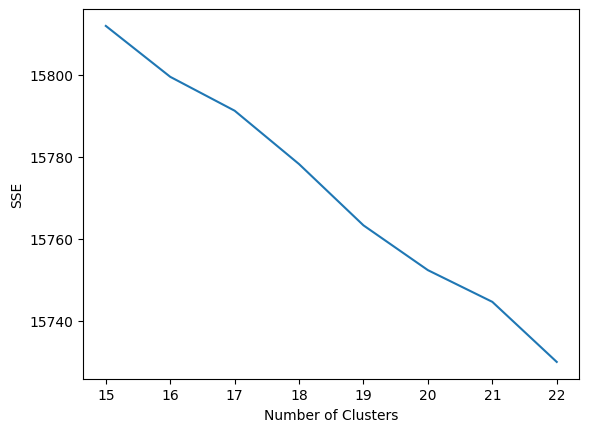

In [ ]:
# SSE: Training Set
plt.plot(num_clusters, sse)
plt.xticks(num_clusters)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
kl = KneeLocator(
  num_clusters, sse, curve="convex", direction="decreasing"
)

In [ ]:
kl.elbow

16

In [ ]:
# silhouette coefficient
silhouette_coefficients = []

for k in num_clusters:
  kmeans = load("kmeans{}.joblib".format(k))
  predictions = kmeans.predict(tfidf_test)
  score = silhouette_score(tfidf_test, predictions)
  silhouette_coefficients.append(score)

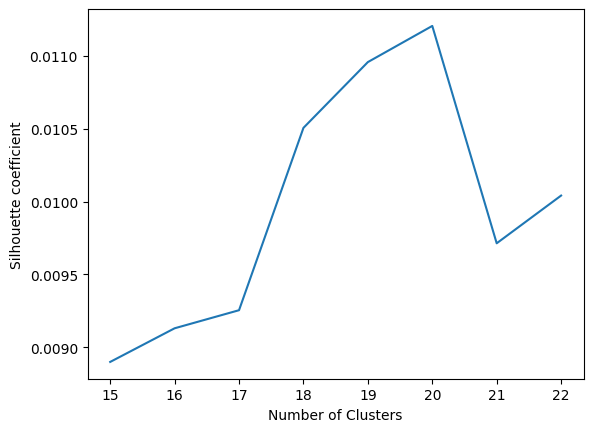

In [ ]:
# Silhouette Coefficient: Testing Set
plt.plot(num_clusters, silhouette_coefficients)
plt.xticks(num_clusters)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette coefficient")
plt.show()

In [ ]:
silhouette_max = silhouette_coefficients.index(max(silhouette_coefficients)) + min(num_clusters)
silhouette_max

20

## Final Clusters

In [ ]:
# optional checkpoint
!unzip kmeans20.zip
silhouette_max = 20

In [ ]:
kmeans = load("kmeans{}.joblib".format(silhouette_max))

In [ ]:
articles_train["clusters"] = kmeans.labels_

In [ ]:
# look at some of the articles in some of the clusters
for i in range(silhouette_max):
  article_group = articles_train['headline'][kmeans.labels_ == i]
  print("There were {} articles in cluster {}, including:".format(len(article_group), i + 1))
  print("\t", "\n\t".join([x for x in article_group[:5]]))

There were 56 articles in cluster 1, including:
	 The fossil expert who left his own footprint behind
	The 'internal battle' when counter culture meets elite sport
	Chen leads as Hanyu falters on 'hole'
	Fear & Gibson avoid Valieva distraction to do 'good job' in ice dance
	New chapter for '100-year-old' rescue cat
There were 61 articles in cluster 2, including:
	 What's Tony Blair's new title? Our timed quiz...
	What did Pope say about parenting? Our timed quiz…
	Who was Britney’s public row with? Our timed quiz…
	What did Bono say about U2’s music? Our timed quiz…
	Quiz of the week: Damon Albarn prefers which artist to Taylor Swift?
There were 64 articles in cluster 3, including:
	 Inside Johnny Depp and Amber Heard's legal battle
	Johnny Depp testifies he never hit Amber Heard
	Depp blames 'burn Amber' text on Monty Python
	Depp v Heard: What you might have missed this week
	Amber Heard says Depp struck her when on drugs
There were 719 articles in cluster 4, including:
	 Big sportin

In [ ]:
articles_train.clusters.max()

19

## Predictions

In [ ]:
# look at the articles from the test day
print("\n".join([x for x in articles_test_day["headline"]]))

Ukraine and Russia both claim control over city
Russia dredges up landing ship hit by Ukraine fire
Dozens freed from church awaiting 'Second Coming'
Israel downs Hezbollah drones headed for gas rig
Adele says Vegas postponement backlash was brutal
Kyrgios fights back to win heated Tsitsipas match
Earthquake kills five near southern Iran coast
Jerry Hall files for divorce from Rupert Murdoch
UK MP facing groping allegation seeks medical support
Two Britons charged by pro-Russian rebels - reports
Gambia bans timber exports to halt smuggling surge
Libyan protesters storm parliament building
What weapons are being supplied to Ukraine?
Elite Russian regiment fights for support and the war for borsch
Russia to take control of huge oil and gas project
Can we say how many people have died in Ukraine?
Return of Africa's most fashionable horse race
Teaching from the trenches in Ukraine
Novelist who traced past to a French debtors' jail
The 'brutal' world of doubles tennis
The 'wandering crickete

In [ ]:
# sort the articles into clusters
articles_test_day["clusters"] = list(kmeans.predict(tfidf_test_day))

In [ ]:
# look at some of the articles in some of the clusters
for i in range(20):
  article_group = articles_test_day['headline'][articles_test_day.clusters == i]
  if len(article_group) == 0:
    print("There were no articles in cluster {}".format(i + 1))
  else:
    print("There were {} articles in cluster {}:".format(len(article_group), i + 1))
    print("\t", "\n\t".join([x for x in article_group[:5]]))

There were no articles in cluster 1
There were no articles in cluster 2
There were no articles in cluster 3
There were 5 articles in cluster 4:
	 The 'wandering cricketer' on the road to stardom
	Ronaldo wants to leave Man Utd this summer
	'Attack best form of defence' for England - Anderson
	Wales beaten by last kick of South Africa thriller
	Scotland goalkeeping great Goram dies aged 58
There were 34 articles in cluster 5:
	 Israel downs Hezbollah drones headed for gas rig
	Adele says Vegas postponement backlash was brutal
	Kyrgios fights back to win heated Tsitsipas match
	Earthquake kills five near southern Iran coast
	Jerry Hall files for divorce from Rupert Murdoch
There were no articles in cluster 6
There were 6 articles in cluster 7:
	 Bolton says Cipollone should testify before Jan. 6 committee
	Democrats run Washington, but the Supreme Court delivers big wins for GOP
	Trump's 'fear factor' shows signs of waning as 2024 Republican hopefuls jockey
	Supreme Court upholds restric

# Step 5: TextRank
(Max)

Select the most representative headline from each cluster with TextRank

In [ ]:
# optional checkpoint
!unzip kmeans20.zip
kmeans = load("kmeans20.joblib")

Archive:  kmeans20.zip
  inflating: kmeans20.joblib         


In [ ]:
# user inputs
  # choose data for TextRank
tr_data = articles_test_day # data to be examined
keys_amount = 30 # number of important words
clust_L = 900000 # legnth of cluster text

# libraries
import spacy
from collections import OrderedDict
import numpy as np
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load("en_core_web_sm")

# create `rep_score` column to hold representative relevance score
tr_data['rep_score'] = 0

#### TextRank function

In [ ]:
class TextRank4Keyword():
    """Extract keywords from text"""

    # key_str = [] # Max added this.
    
    def __init__(self):
        self.d = 0.85 # damping coefficient, usually is .85
        self.min_diff = 1e-5 # convergence threshold
        self.steps = 10 # iteration steps
        self.node_weight = None # save keywords and its weight

    
    def set_stopwords(self, stopwords):  
        """Set stop words"""
        for word in STOP_WORDS.union(set(stopwords)):
            lexeme = nlp.vocab[word]
            lexeme.is_stop = True
    
    def sentence_segment(self, doc, candidate_pos, lower):
        """Store those words only in cadidate_pos"""
        sentences = []
        for sent in doc.sents:
            selected_words = []
            for token in sent:
                # Store words only with cadidate POS tag
                if token.pos_ in candidate_pos and token.is_stop is False:
                    if lower is True:
                        selected_words.append(token.text.lower())
                    else:
                        selected_words.append(token.text)
            sentences.append(selected_words)
        return sentences
        
    def get_vocab(self, sentences):
        """Get all tokens"""
        vocab = OrderedDict()
        i = 0
        for sentence in sentences:
            for word in sentence:
                if word not in vocab:
                    vocab[word] = i
                    i += 1
        return vocab
    
    def get_token_pairs(self, window_size, sentences):
        """Build token_pairs from windows in sentences"""
        token_pairs = list()
        for sentence in sentences:
            for i, word in enumerate(sentence):
                for j in range(i+1, i+window_size):
                    if j >= len(sentence):
                        break
                    pair = (word, sentence[j])
                    if pair not in token_pairs:
                        token_pairs.append(pair)
        return token_pairs
        
    def symmetrize(self, a):
        return a + a.T - np.diag(a.diagonal())
    
    def get_matrix(self, vocab, token_pairs):
        """Get normalized matrix"""
        # Build matrix
        vocab_size = len(vocab)
        g = np.zeros((vocab_size, vocab_size), dtype='float')
        for word1, word2 in token_pairs:
            i, j = vocab[word1], vocab[word2]
            g[i][j] = 1
            
        # Get Symmeric matrix
        g = self.symmetrize(g)
        
        # Normalize matrix by column
        norm = np.sum(g, axis=0)
        g_norm = np.divide(g, norm, where=norm!=0) # this is ignore the 0 element in norm
        
        return g_norm

    
    def get_keywords(self, number=10):
        """Print top number keywords"""
        node_weight = OrderedDict(sorted(self.node_weight.items(), key=lambda t: t[1], reverse=True))
        for i, (key, value) in enumerate(node_weight.items()):
            print(key + ' - ' + str(value))
            if i > number:
                break
    

    def get_keys_weights(self, number=10): # Max wrote this.
        """Print top number keywords"""
        node_weight = OrderedDict(sorted(self.node_weight.items(), key=lambda t: t[1], reverse=True))

        for i, (key, value) in enumerate(node_weight.items()):

            key_str.append(key) # key_str.append(str(key))
            tr_weights.append(value)

            if i > number:
                break

        
    def analyze(self, text, 
                candidate_pos=['NOUN', 'PROPN'], 
                window_size=4, lower=False, stopwords=list()):
        """Main function to analyze text"""
        
        # Set stop words
        self.set_stopwords(stopwords)
        
        # Pare text by spaCy
        doc = nlp(text)
        
        # Filter sentences
        sentences = self.sentence_segment(doc, candidate_pos, lower) # list of list of words
        
        # Build vocabulary
        vocab = self.get_vocab(sentences)
        
        # Get token_pairs from windows
        token_pairs = self.get_token_pairs(window_size, sentences)
        
        # Get normalized matrix
        g = self.get_matrix(vocab, token_pairs)
        
        # Initionlization for weight(pagerank value)
        pr = np.array([1] * len(vocab))
        
        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr = (1-self.d) + self.d * np.dot(g, pr)
            if abs(previous_pr - sum(pr))  < self.min_diff:
                break
            else:
                previous_pr = sum(pr)

        # Get weight for each node
        node_weight = dict()
        for word, index in vocab.items():
            node_weight[word] = pr[index]
        
        self.node_weight = node_weight

#### create text per cluster

In [ ]:
clust = tr_data['clusters'].max()

In [ ]:
for c_group in range(clust+1): # for c_group in range(clust+1)

  # Code from: https://www.pythontutorial.net/python-basics/python-read-text-file/
  f = open("cluster{}.txt".format(c_group), "w") # "a"

  for i in range(len(tr_data)):
    if tr_data["clusters"][i] == c_group:
      # Code from: https://www.geeksforgeeks.org/python-append-to-a-file/
      tr_data["clean_article"][i] = tr_data["clean_article"][i].encode('ascii', 'ignore').decode('ascii') # igore special characters
      f.writelines(tr_data["clean_article"][i]) # f.write(clust_csv["clean_Heading"][i])
      f.write(" ") 
      
  f.close()

<ipython-input-23-912e23708928>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr_data["clean_article"][i] = tr_data["clean_article"][i].encode('ascii', 'ignore').decode('ascii') # igore special characters


In [ ]:
for c_group in range(clust+1):

  f = open("cluster{}.txt".format(c_group), "r") # r
  c_text = f.read()
  
  if len(c_text) > 900000:
    c_text = c_text[0:900000]
  else:
    pass
  
  f.close()

In [ ]:
# https://pythonexamples.org/python-replace-string-in-file

for c_group in range(clust+1):

  fin = open("cluster{}.txt".format(c_group), "rt")
  data = fin.read()

  if len(data) > clust_L:
    data = data[0:clust_L]
  else:
    pass

  fin.close() 
  fin = open("cluster{}.txt".format(c_group), "wt")
  fin.write(data)
  fin.close()

In [ ]:
# open .txt
# read string
# limit characters if legnth
# re-write string
# close .txt

#### assign relevance value within cluster

In [ ]:
# content = open("cluster{}.txt".format(c_group),"r")

In [ ]:
tr4w = TextRank4Keyword()

# loop through clusters
for c_group in range(clust+1): 

  # TextRank Analysis
  content = open('cluster{}.txt'.format(c_group)).read()
  tr4w.analyze(content, candidate_pos = ['NOUN', 'PROPN'], window_size=4, lower=False)

  # creates a dataframe with keys and values
  key_str = [] # each iteration begins with empty set
  tr_weights = []
  tr4w.get_keys_weights(keys_amount)

  key_str = pd.DataFrame(key_str)
  key_str = key_str.rename(columns={0: "key"})
  tr_weights = pd.DataFrame(tr_weights)
  tr_weights = tr_weights.rename(columns={0: "tr_w"})
  keys_weights = key_str.join(tr_weights)

  # loop through each point
  for i in range(len(tr_data)):
    
    if tr_data['clusters'][i] == c_group:

      # loops through each key
      for j in range(len(keys_weights)):

        if search(keys_weights['key'][j], tr_data['clean_article'][i]):
          tr_data['rep_score'][i] += keys_weights['tr_w'][j]

    else:
      pass

<ipython-input-27-34610ebe9747>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr_data['rep_score'][i] += keys_weights['tr_w'][j]


#### select most representative articles within each cluster

In [ ]:
tr_data

In [ ]:
top_arts = []
for c_group in range(clust+1):
  
  if any(tr_data['clusters'] == c_group):
    c_max_id = tr_data[tr_data['clusters'] == c_group]['rep_score'].idxmax()
    c_max_head = tr_data['headline'][c_max_id]
    c_max_art = tr_data['article'][c_max_id]

    top_arts.append(c_max_id)
    print("Cluster {} most representative heading and article (index: {}) \n {} \n {} \n ".format(c_group+1, c_max_id, c_max_head, c_max_art))

Cluster 4 most representative heading and article (index: 20) 
 The 'wandering cricketer' on the road to stardom 
 Before India's squad for the 2014 Under-19 cricket World Cup left Bangalore, Naushad Khan had come down to the city to meet his son. Sarfaraz Khan had found a spot as a batter in the 15-man squad alongside the likes of Shreyas Iyer, Sanju Samson, Deepak Hooda and Kuldeep Yadav. The side was coached by Bharat Arun, who would later become the architect of India's fast-bowling revolution. When Arun was told that Naushad was there, he called him up to his room. "He told me not to worry and said everything would be fine," Naushad recalls. "I told him, 'sir, please look after Sarfaraz, he is a little naughty'." Arun told him that Sarfaraz's humour was in fact an asset for the team. "He isn't afraid to stare down Australian and Pakistani players and crack some jokes. That lightens the mood. This is his attitude. And the day he loses it, his performance will also suffer," Arun say

## Qualitative Analysis

I will manually read 10 articles for each cluster at random and write a qualitative analysis to see how well the representative article represents the topic cluster.

In [ ]:
rand_arts = []

for i in range(20):
  i = random.randrange(len(3))
  rand_arts.append(i)

In [ ]:
rand_arts

[1033,
 809,
 169,
 81,
 488,
 48,
 937,
 998,
 498,
 427,
 308,
 984,
 119,
 1102,
 870,
 856,
 504,
 234,
 727,
 23]

In [ ]:
tr_data['clusters'][984]

6

In [ ]:
tr_data['article'][984]

'WASHINGTON — A federal judge indicated Wednesday that then-President Donald Trump\'s remarks on Jan. 6 telling a crowd to "fight like hell" before the Capitol attack could have signaled to his supporters that he wanted them "to do something more" than just protest. In a court order for the case against Jan. 6 defendant Alexander Sheppard, U.S. District Court Judge John Bates ruled that Sheppard could not raise the "public authority" defense at trial after his lawyer argued Trump had authorized his client\'s actions at the Capitol that day. Bates, who was appointed to the court by former President George W. Bush, rejected that argument, ruling that "President Trump neither stated nor implied that entering the restricted area of the Capitol grounds and the Capitol building or impeding the certification of the electoral vote was lawful," and therefore a public authority defense was not viable. "These words only encourage those at the rally to march to the Capitol — nothing more — and do 

In [ ]:
tr_data['headline'][686]

'Native Hawaiian women and girls experience sex trafficking and violence at alarming rates, report says'

In [ ]:
tr_data['clusters'][686]

1

In [ ]:
rand_arts_2 = []

for i in range(20):
  i = random.randrange(1200)
  rand_arts_2.append(i)

In [ ]:
rand_arts_2

[211,
 482,
 206,
 1124,
 566,
 299,
 1030,
 2,
 1186,
 1180,
 118,
 455,
 467,
 639,
 935,
 1114,
 975,
 197,
 686,
 935]

# Step 6: Summarization

In [ ]:
# http://datageek.fr/abstractive-summarization-with-huggingface-pre-trained-models/
!pip install transformers
!pip install sentencepiece
from transformers import pipeline

!pip install rouge
from rouge import Rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
text = []
for i in range(len(articles_test_day)):
  text.append(articles_test_day.article[i].replace(articles_test_day.lead3[i], "")) # input data is the article minus LEAD-3
articles_test_day["text"] = text

In [ ]:
articles_test_day.lead3[0]

'Martha Stewart is in mourning after her four dogs mistakenly attacked and killed one of her beloved cats, Princess Peony. The 80-year-old celebrity businesswoman shared the news on Instagram Sunday with a photo of a grave being dug out by workers. “burying the beautiful and unusual Princess Peony,” Stewart wrote. “the four dogs mistook her for an interloper and killed her defenseless little self. i will miss her very badly. RIP beauty.”'

In [ ]:
articles_test_day.text[0]

" Shortly after her announcement, Stewart shared another Instagram post of the 12-year-old calico Persion cat's close-up shot on Instagram. “this was the Princess Peony,” she wrote. She shared the same photo on her Instagram Stories, captioned: “RIP beauty cat Princess Peony!!!” Alongside her twin sister, Empress Tang, Princess Peony was born on May 11, 2009, according to Stewart's website. The cats were both moved to Stewart’s farm four months later."

## Generate models

In [ ]:
# initialize summarizers for various models
summarizer_bart = pipeline("summarization", model = "facebook/bart-large-cnn")
summaries_bart = summarizer_bart(list(articles_test_day.text), truncation = True)

In [ ]:
summarizer_pegasus = pipeline("summarization", model = "google/pegasus-cnn_dailymail")
summaries_pegasus = summarizer_pegasus(list(articles_test_day.text), truncation = True)

## Evaluation

### Quantitative

In [ ]:
rouge = Rouge()

In [ ]:
references = list(articles_test_day.lead3)

In [ ]:
rouge_scores = dict()

In [ ]:
hypotheses_bart = [x["summary_text"] for x in summaries_bart]
rouge_scores["BART"] = rouge.get_scores(hypotheses_bart, references, avg = True)

In [ ]:
hypotheses_pegasus = [x["summary_text"] for x in summaries_pegasus]
rouge_scores["Pegasus"] = rouge.get_scores(hypotheses_pegasus, references, avg = True)

In [ ]:
models = ["BART", "Pegasus"]

In [ ]:
rouge_results = pd.DataFrame({"Rouge 1": [rouge_scores[mod]["rouge-1"]["f"] for mod in models],
                             "Rouge 2": [rouge_scores[mod]["rouge-2"]["f"] for mod in models],
                             "Rouge L": [rouge_scores[mod]["rouge-l"]["f"] for mod in models]})
rouge_results.index = models

In [ ]:
rouge_results = rouge_results.transpose()
rouge_results["Difference"] = rouge_results.BART - rouge_results.Pegasus

In [ ]:
print(rouge_results.style.to_latex())

\begin{tabular}{lrrr}
 & BART & Pegasus & Difference \\
Rouge 1 & 0.209470 & 0.199208 & 0.010262 \\
Rouge 2 & 0.041628 & 0.042619 & -0.000991 \\
Rouge L & 0.192788 & 0.174980 & 0.017808 \\
\end{tabular}



In [ ]:
articles_test_day["BART"] = hypotheses_bart
articles_test_day["Pegasus"] = hypotheses_pegasus

In [ ]:
bart_scores = rouge.get_scores(hypotheses_bart, references)
pegasus_scores = rouge.get_scores(hypotheses_pegasus, references)

articles_test_day["BART_r1_recall"] = [x["rouge-1"]["r"] for x in bart_scores]
articles_test_day["BART_r1_precision"] = [x["rouge-1"]["p"] for x in bart_scores]
articles_test_day["BART_r1_f1"] = [x["rouge-1"]["f"] for x in bart_scores]

articles_test_day["BART_r2_recall"] = [x["rouge-2"]["r"] for x in bart_scores]
articles_test_day["BART_r2_precision"] = [x["rouge-2"]["p"] for x in bart_scores]
articles_test_day["BART_r2_f1"] = [x["rouge-2"]["f"] for x in bart_scores]

articles_test_day["BART_rl_recall"] = [x["rouge-l"]["r"] for x in bart_scores]
articles_test_day["BART_rl_precision"] = [x["rouge-l"]["p"] for x in bart_scores]
articles_test_day["BART_rl_f1"] = [x["rouge-l"]["f"] for x in bart_scores]

In [ ]:
articles_test_day.to_csv("articles_test_day.csv")

### Qualitative

In [ ]:
# only look at representative articles
articles_test_day["representative"] = [1 if i in top_arts else 0 for i in range(len(articles_test_day))]
articles_sum = articles_test_day.loc[articles_test_day.representative == 1].reset_index(drop = True)
# articles_sum = pd.read_csv("articles_sum.csv")

In [ ]:
random.seed(10)
samp = random.sample(range(len(articles_sum)), k = 3)

In [ ]:
articles_sum.article[samp[0]]

"Test your news knowledge against the clock. Can you outscore your friends? If you cannot see the quiz, follow this link. Want more of the same? Try last week's teaser. Or take Friday's quiz of the week's news. What information do we collect from this quiz? Privacy notice."

In [ ]:
hypotheses_bart[samp[0]]

"Quiz is part of a series of tests designed to test your knowledge of events in the news. The results of this quiz may be used to help people understand the news stories you saw on CNN.com. Use the Daily Discussion to help students understand today's featured news stories. The Daily Discussion is open to everyone."

In [ ]:
hypotheses_pegasus[samp[0]]

'What information do we collect on this quiz?<n>What information do we collect on this quiz?<n>What information do we collect on this quiz?<n>What information do we collect on this quiz?'

In [ ]:
articles_sum.article[samp[1]]

'Actress June Brown, who played the much-loved character Dot Cotton on EastEnders for more than three decades, has died at the age of 95. Her family said they were "deeply saddened" to announce that their "beloved mother" had died "very peacefully" at her home on Sunday. EastEnders actor Adam Woodyatt described her as an "incredible woman". Dot Cotton was one of the BBC soap\'s longest-running characters and a favourite with viewers. Brown first appeared in the series in 1985, the year EastEnders was created. She stayed until 1993, returning to play the same character from 1997 until 2020. An EastEnders spokesperson said: "There are not enough words to describe how much June was loved and adored by everyone at EastEnders, her loving warmth, wit and great humour will never be forgotten. "June created one of the most iconic characters in Dot Cotton, not just in soap but in British television, and having appeared in 2884 episodes, June\'s remarkable performances created some of EastEnders

In [ ]:
hypotheses_bart[samp[1]]

"Dot Cotton was one of the BBC soap's longest-running characters. Brown first appeared in the series in 1985, the year EastEnders was created. She stayed until 1993, returning to play the same character from 1997 until 2020. Her biggest storylines included Nasty Nick's murder plot and Ethel's morphine overdose."

In [ ]:
hypotheses_pegasus[samp[1]]

"June Brown first appeared in the BBC soap in 1985, the year it was created .<n>She stayed until 1993, returning to play the same character from 1997 until 2020 .<n>Brown's career had incorporated stage, film and television ."

In [ ]:
articles_sum.article[samp[2]]

'Prime Minister Boris Johnson has said "we will not rest until justice is done", amid further evidence of continued atrocities in Ukraine. Distressing images of civilian bodies in the streets of Bucha, near Kyiv, have led to international outrage over Russia\'s actions. Foreign Secretary Liz Truss has called for Russia to be suspended from the United Nations\' Human Rights Council. She has also pushed for tougher international sanctions on Russia. In a news conference in the Polish capital Warsaw, Ms Truss said: "What we have seen in the streets of Irpin and Bucha are scenes that we will never forget. We have seen butchery, evidence of rape and sexual violence, as well as the indiscriminate killing of civilians." She added: "We are clear, that after these appalling crimes, Russia has no place on the Human Rights Council". A senior Westminster source has told the BBC the government is considering further action against Russian soldiers as individuals. Officials are looking at further sa

In [ ]:
hypotheses_bart[samp[2]]

'Foreign Secretary says Russia has no place on the Human Rights Council. She has also pushed for tougher international sanctions on Russia. A senior Westminster source has said the government is considering further action against Russian soldiers as individuals. Officials are looking at further sanctions that could target captains, majors and colonels in the Russian military.'

In [ ]:
hypotheses_pegasus[samp[2]]

'Foreign Secretary Elizabeth Truss has called for tougher sanctions on Russia .<n>She said the UK is considering further action against Russian soldiers as individuals .<n>Ms Truss added that Nato needs to use a meeting this week to "step up support"<n>She said the UK would do more "to ramp up the pressure" on Russia .'